In [1]:
# aggregate similar names (eg spellings of Aaliyah)
# bonus: generate label "variant_of":
# attach the corresponding "properly-spelled" name to each name
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt

import os
import sys
import pandas as pd


# add src folder to path, and auto-reload it when it changes
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from src import util

data_folder = os.path.abspath(os.path.join('..','data','names'))
col_names = ['name','gender','count']
df = util.load_stitch_files(data_folder, col_names, 'txt')
df.sample(5)



,name,gender,count,year
912711,Mauria,F,6,1982
1360532,Shallah,M,6,2000
882432,Darshaun,M,5,1980
1386533,Basir,M,11,2001
645162,Juanito,M,5,1965


In [2]:


def lev_dist(u, v):
    """ Compute Levenshtein (aka Edit) distance between 2 strings """
    if u == '' or v == '':
        return max(len(u), len(v))
    return min(
        lev_dist(u, v[1:]) + 1, # 'x'+u = v
        lev_dist(u[1:], v) + 1, # u = 'x'+v
        lev_dist(u[1:], v[1:]) + (0 if u[0] == v[0] else 1) # char matching
    )


def lev_dist_wf(u, v):
    """ Optimized Levenshtein distance using dynamic programming. 
    Compute distances between prefixes only once, and store them.
    https://en.wikipedia.org/wiki/Wagner%E2%80%93Fischer_algorithm
    """
    n = len(u)
    m = len(v)
    d = [[None for j in range(m+1)] for i in range(n+1)]
    for i in range(n+1):
        d[i][0] = i
    for j in range(m+1):
        d[0][j] = j
    for i in range(1,n+1):
        for j in range(1,m+1):
            if u[i-1] == v[j-1]:
                d[i][j] = d[i-1][j-1]
            else:
                d[i][j] = min(
                    d[i-1][j]+1, # deletion
                    d[i][j-1]+1, # insertion
                    d[i-1][j-1]+1 # substitution
                )
    return d[n][m]
    

def test_lev_dist(f):
    assert f('ab','a') == 1
    assert f('ab','ac') == 1
    assert f('ab','zb') == 1
    assert f('ab','ab') == 0
    assert f('sitting','kitten') == 3

test_lev_dist(lev_dist)
test_lev_dist(lev_dist_wf)


In [3]:
ddf = (
    df
    .query("gender=='M'")
    .groupby('name')
    .agg({'count':sum})
)
ddf = ddf[ddf.index.str.startswith('J')].nlargest(30, 'count')
# ddf.loc['James',:]
# ddf.query("name=='James'")
# #ddf.index.startswith('A')
# ddf.filter(like='bbi', axis=0)
# https://stackoverflow.com/a/46052461
ddf.head()

,count
name,
James,5150472
John,5115466
Joseph,2603445
Joshua,1202454
Jason,1028809


In [4]:
import numpy as np
from sklearn.cluster import dbscan, DBSCAN

# https://scikit-learn.org/stable/faq.html#how-do-i-deal-with-string-data-or-trees-graphs
data = ["chips", "chip", "ships",
       "cat", "car", "cast",
       "blue", "bleu", "blues"]
data = list(ddf.index)
def lev_metric(x, y):
    i, j = int(x[0]), int(y[0]) # extract indices
    return lev_dist_wf(data[i], data[j])

X = np.arange(len(data)).reshape(-1, 1)
db = DBSCAN(metric=lev_metric, eps=1, min_samples=2, algorithm='brute').fit(X)
# print('labels:', db.labels_)
# print('n_clusters:',len(set(db.labels_)))
ddf['cluster'] = db.labels_
ddf.sort_values(by=['cluster','name'], ascending=['True','True'])


,count,cluster
name,,
Jack,685056,-1
Jackson,228925,-1
Jacob,919481,-1
James,5150472,-1
Jared,199382,-1
Jason,1028809,-1
Jay,188764,-1
Jayden,200865,-1
Jeffery,229023,-1


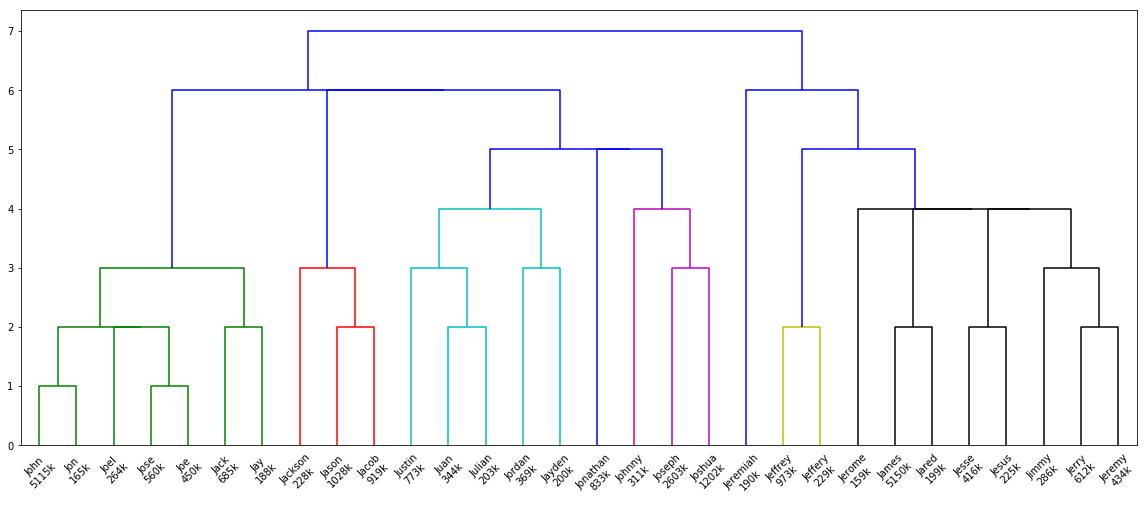

In [5]:
from scipy.spatial.distance import pdist, squareform
import random
from scipy.cluster.hierarchy import dendrogram, linkage

random.seed(13)

# strings = ['Julie','Julien','Julia','Julian']
strings = list(ddf.index)
labels = [k+'\n'+str(int(v/1000))+'k' for k,v in dict(ddf['count']).items()]

# https://stackoverflow.com/a/46807953
# prepare 2 dimensional array M x N (M entries (3) with N dimensions (1)) 
transformed_strings = np.array(strings).reshape(-1,1)
# calculate condensed distance matrix by wrapping the Levenshtein distance function
distance_matrix = pdist(transformed_strings,lambda x,y: lev_dist_wf(x[0],y[0]))

# linkage and dendogram
Z = linkage(distance_matrix, 'complete') # 'single' is min, 'complete' max
fig = plt.figure(figsize=(20, 8))
dn = dendrogram(Z, labels=labels)
plt.show()
